In [1]:
import torchvision
import torch
from torch import nn, optim
from torchsummary import summary
from torch.optim import lr_scheduler
from torchvision import models

import import_ipynb
import baselines
import data_preparation

importing Jupyter notebook from baselines.ipynb
importing Jupyter notebook from data_preparation.ipynb
['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


Loading data

In [2]:
baselines.seed_torch()
device = data_preparation.device

In [2]:
# english
class_names = data_preparation.class_names
img_datasets = data_preparation.img_datasets
dataloaders = data_preparation.dataloaders
dataset_sizes = data_preparation.dataset_sizes
class_names = data_preparation.class_names

In [3]:
# russian
class_names_rus = data_preparation.class_names_rus
img_datasets_rus = data_preparation.img_datasets_rus
dataloaders_rus = data_preparation.dataloaders_rus
dataset_sizes_rus = data_preparation.dataset_sizes_rus
class_names_rus = data_preparation.class_names_rus

In [4]:
def freeze_layers(model, num_layers):
    cnt = 0
    for child in model.features.children():
        if cnt < num_layers:
            for param in child.parameters():
                param.requires_grad = False
        cnt += 1
    
    num_features = 960
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 26),
        nn.Softmax(dim=-1))
    
    mobile_v3 = model.cuda()
    
    return mobile_v3

#### OUT OF THE BOX MODEL (only last layer trained)

default estimated weight 141.59 MB, eval accuracy: 0.39, loss: 0.0473

In [6]:
v1_default = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V2')

In [7]:
for param in v1_default.parameters():
    param.requires_grad = False
num_features = 960
v1_default.classifier = nn.Sequential(
    nn.Linear(num_features, 26),
    nn.Softmax(dim=-1))

v1_default = v1_default.to(device)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(v1_default.parameters(), lr=1e-3)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
v1_trained, v1_losses, v1_accuracies, v1_roc_aucs = baselines.train(v1_default, loss_fn, optimizer, lr_scheduler, dataloaders, dataset_sizes, num_epochs=10, verbose=1)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 4.0m 56.2146s
Best val Acc: 0.3830
Best val Roc-Auc: 0.8604


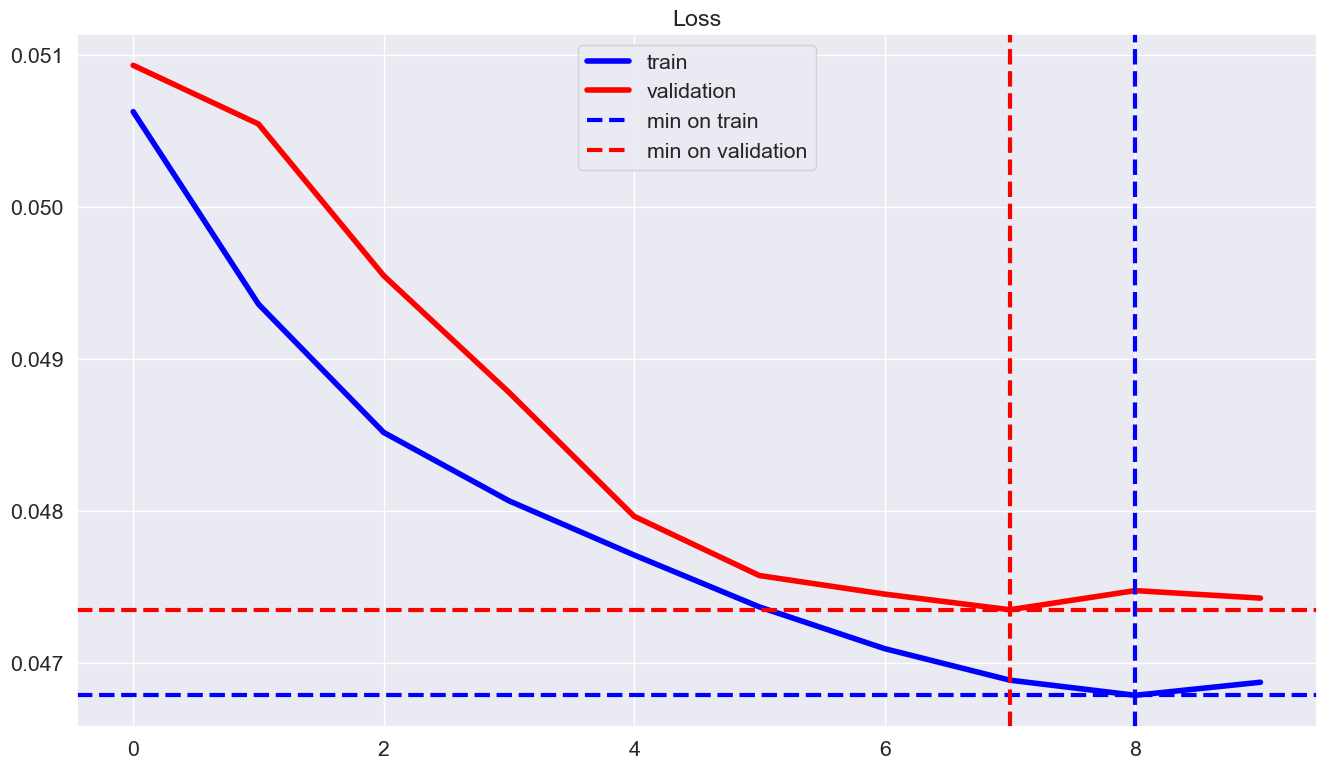

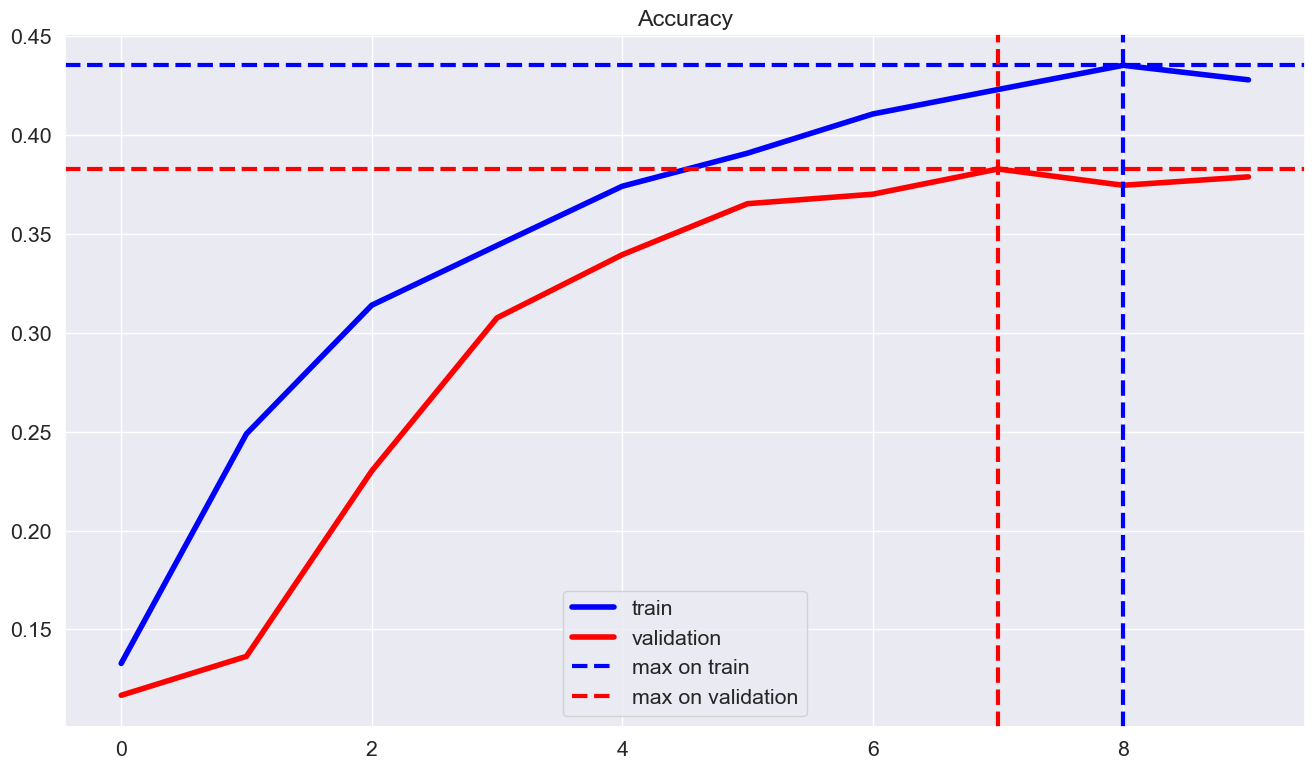

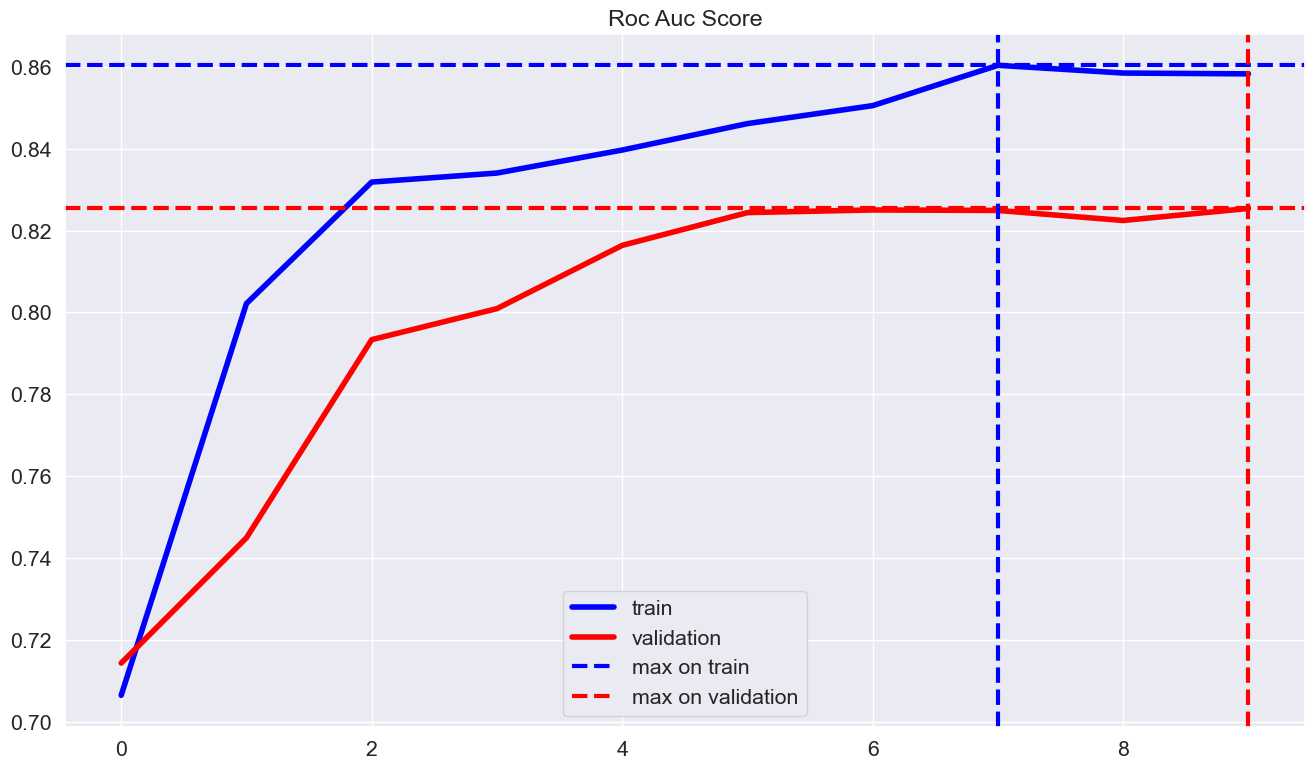

In [10]:
baselines.train_plot(v1_losses, v1_accuracies, v1_roc_aucs)

In [11]:
baselines.evaluate(v1_trained, dataloaders['test'])

c:\Users\Nikita\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.2879177377892031,
 0.8268034188034188,
 0.26259269678608155,
 0.28717948717948716)

In [12]:
torch.cuda.empty_cache()

#### SEARCHING FOR BEST DEPTH OF FREEZING

In [6]:
mds, losses, accuracies, roc_aucs = [], [], [], []
for num_layers in range(14, 5, -1):
    model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V2')
    model = freeze_layers(model, num_layers)
    
    from torch.optim import lr_scheduler
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    m_trained, m_losses, m_accuracies, m_roc_aucs = baselines.train(model, loss_fn, optimizer, lr_scheduler, dataloaders, dataset_sizes, num_epochs=10, verbose=1)
    
    mds.append(m_trained)
    losses.append(m_losses)
    accuracies.append(m_accuracies)
    roc_aucs.append(m_roc_aucs)
    torch.cuda.empty_cache()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 5.0m 40.1012s
Best val Acc: 0.7872
Best val Roc-Auc: 0.9894


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 5.0m 4.9259s
Best val Acc: 0.8333
Best val Roc-Auc: 0.9935


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 5.0m 10.4302s
Best val Acc: 0.8543
Best val Roc-Auc: 0.9951


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 5.0m 24.9945s
Best val Acc: 0.8650
Best val Roc-Auc: 0.9963


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 5.0m 23.4736s
Best val Acc: 0.8831
Best val Roc-Auc: 0.9963


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 5.0m 26.4948s
Best val Acc: 0.8788
Best val Roc-Auc: 0.9949


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 5.0m 31.2876s
Best val Acc: 0.8770
Best val Roc-Auc: 0.9958


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 5.0m 36.5241s
Best val Acc: 0.8794
Best val Roc-Auc: 0.9970


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 5.0m 26.6953s
Best val Acc: 0.8796
Best val Roc-Auc: 0.9958


Plotting results

In [7]:
for num_layers in range(5, -1, -1):
    model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V2')
    model = freeze_layers(model, num_layers)
    
    from torch.optim import lr_scheduler
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    m_trained, m_losses, m_accuracies, m_roc_aucs = baselines.train(model, loss_fn, optimizer, lr_scheduler, dataloaders, dataset_sizes, num_epochs=10, verbose=1)
    
    mds.append(m_trained)
    losses.append(m_losses)
    accuracies.append(m_accuracies)
    roc_aucs.append(m_roc_aucs)
    
    torch.cuda.empty_cache()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
baselines.save(data=[accuracies, losses, roc_aucs], file_names=['comp_accs', 'comp_loss', 'comp_aucs'])

In [9]:
accuracies, losses, roc_aucs = baselines.load(['comp_accs', 'comp_loss', 'comp_aucs'])

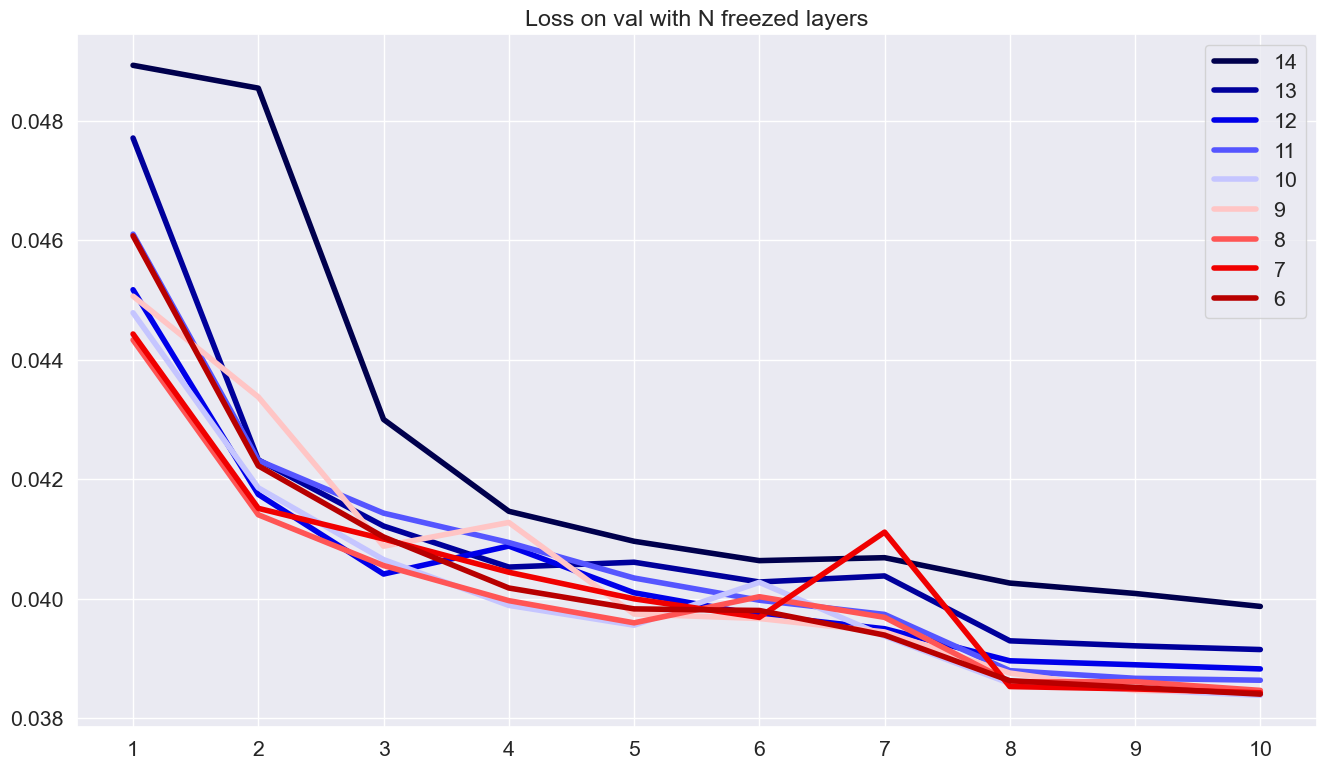

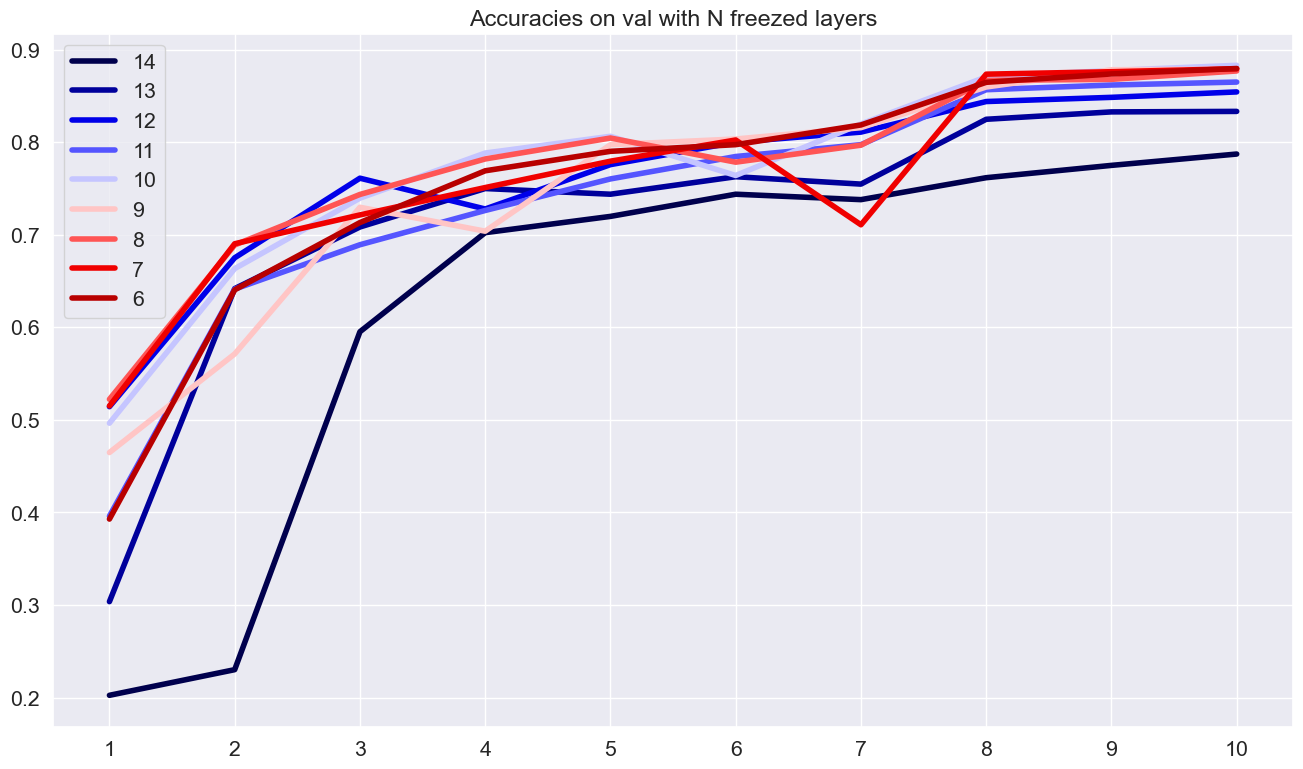

In [10]:
baselines.comparison_plots(losses, accuracies, [str(i) for i in range(14, -1, -1)], num_epochs=10, titles=['Loss on val with N freezed layers', 'Accuracies on val with N freezed layers'], linestyle='-')

In [ ]:
best_model = [min(i['val']) for i in losses].index(min([min(i['val']) for i in losses]))
best_model

#### ADDING DENSE NET TO BEST MODEL

basic model with one fc layer

In [ ]:
from torch.optim import lr_scheduler

In [ ]:
eng_model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V2')
eng_model = freeze_layers(eng_model, 4)


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(eng_model.parameters(), lr=1e-3)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
eng_md_trained, eng_md_losses, eng_md_accuracies, eng_md_roc_aucs = baselines.train(eng_model, loss_fn, optimizer, lr_scheduler, dataloaders, dataset_sizes, num_epochs=20, verbose=1)
torch.cuda.empty_cache()

In [ ]:
baselines.evaluate(eng_md_trained, dataloaders['test'])

In [ ]:
baselines.evaluate(eng_md_trained, dataloaders['val'])

searching for best number and shape of layers

In [7]:
from torch.optim import lr_scheduler

In [8]:
eng_model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V2')
eng_model = freeze_layers(eng_model, 4)

In [9]:
eng_model.classifier = nn.Sequential(
    nn.Linear(960, 158),
    nn.BatchNorm1d(num_features=158),
    nn.ReLU(158),
    nn.Linear(158, 26), 
    nn.Softmax(dim=-1)
)
eng_model = eng_model.cuda()

In [10]:
summary(eng_model, (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 122, 122]             432
       BatchNorm2d-2         [-1, 16, 122, 122]              32
         Hardswish-3         [-1, 16, 122, 122]               0
            Conv2d-4         [-1, 16, 122, 122]             144
       BatchNorm2d-5         [-1, 16, 122, 122]              32
              ReLU-6         [-1, 16, 122, 122]               0
            Conv2d-7         [-1, 16, 122, 122]             256
       BatchNorm2d-8         [-1, 16, 122, 122]              32
  InvertedResidual-9         [-1, 16, 122, 122]               0
           Conv2d-10         [-1, 64, 122, 122]           1,024
      BatchNorm2d-11         [-1, 64, 122, 122]             128
             ReLU-12         [-1, 64, 122, 122]               0
           Conv2d-13           [-1, 64, 61, 61]             576
      BatchNorm2d-14           [-1, 64,

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(eng_model.parameters(), lr=1e-3)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.15)
two_fc_trained, two_fc_losses, two_fc_accuracies, two_fc_roc_aucs = baselines.train(eng_model, loss_fn, optimizer, lr_scheduler, dataloaders, dataset_sizes, num_epochs=20, savename='two_fc', verbose=1)
torch.cuda.empty_cache()

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training complete in 11.0m 53.9728s
Best val Acc: 0.9302
Best val Roc-Auc: 0.9980


In [12]:
model = eng_model
model.load_state_dict(torch.load('models/two_fc'))
model = model.cuda()
baselines.evaluate(model, dataloaders['test'])

(0.9588688946015425,
 0.9994354090354091,
 0.9622900195581191,
 0.9580586080586081)

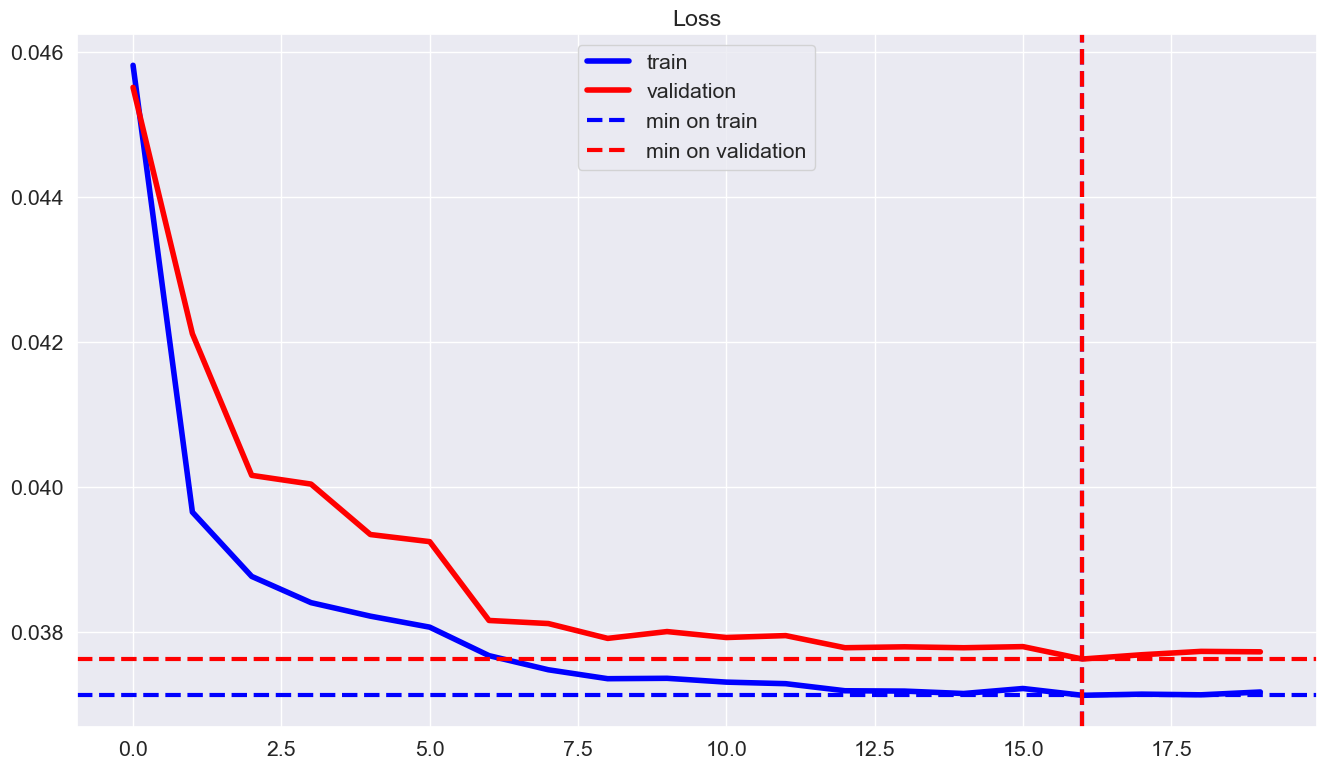

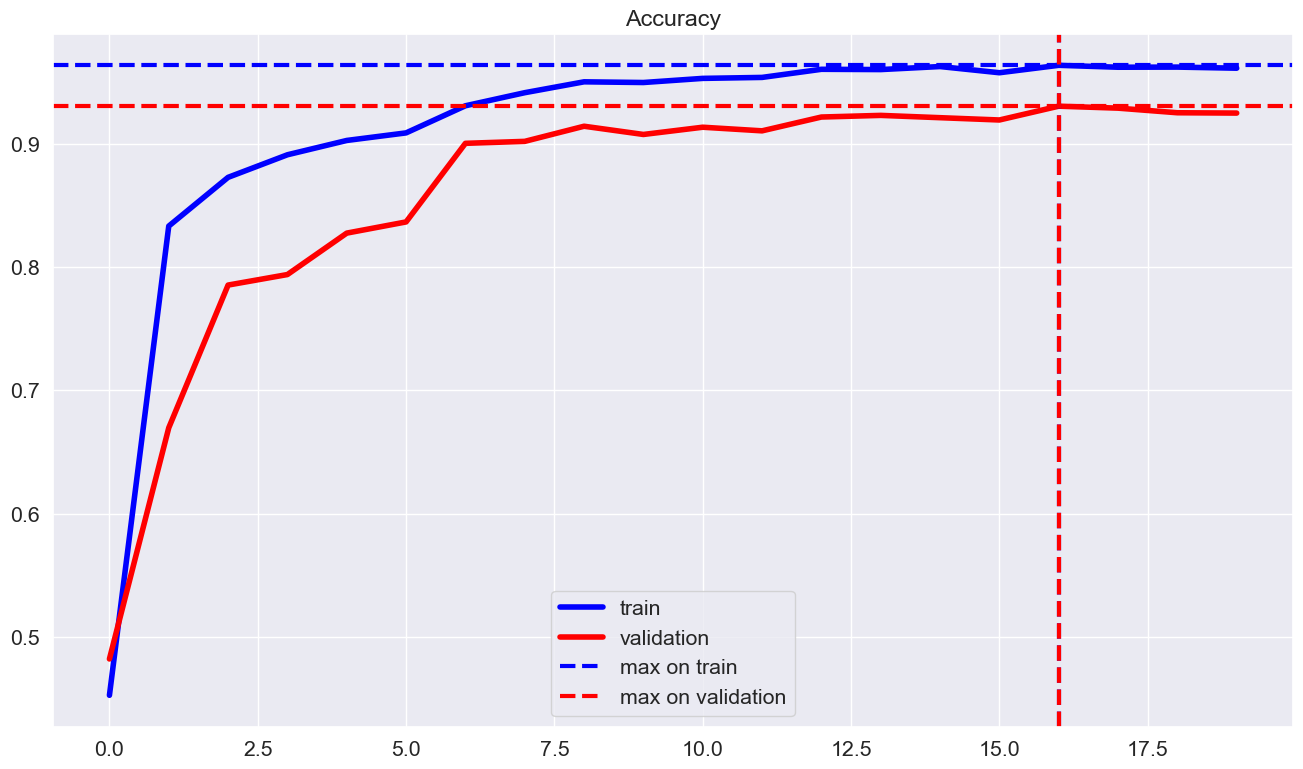

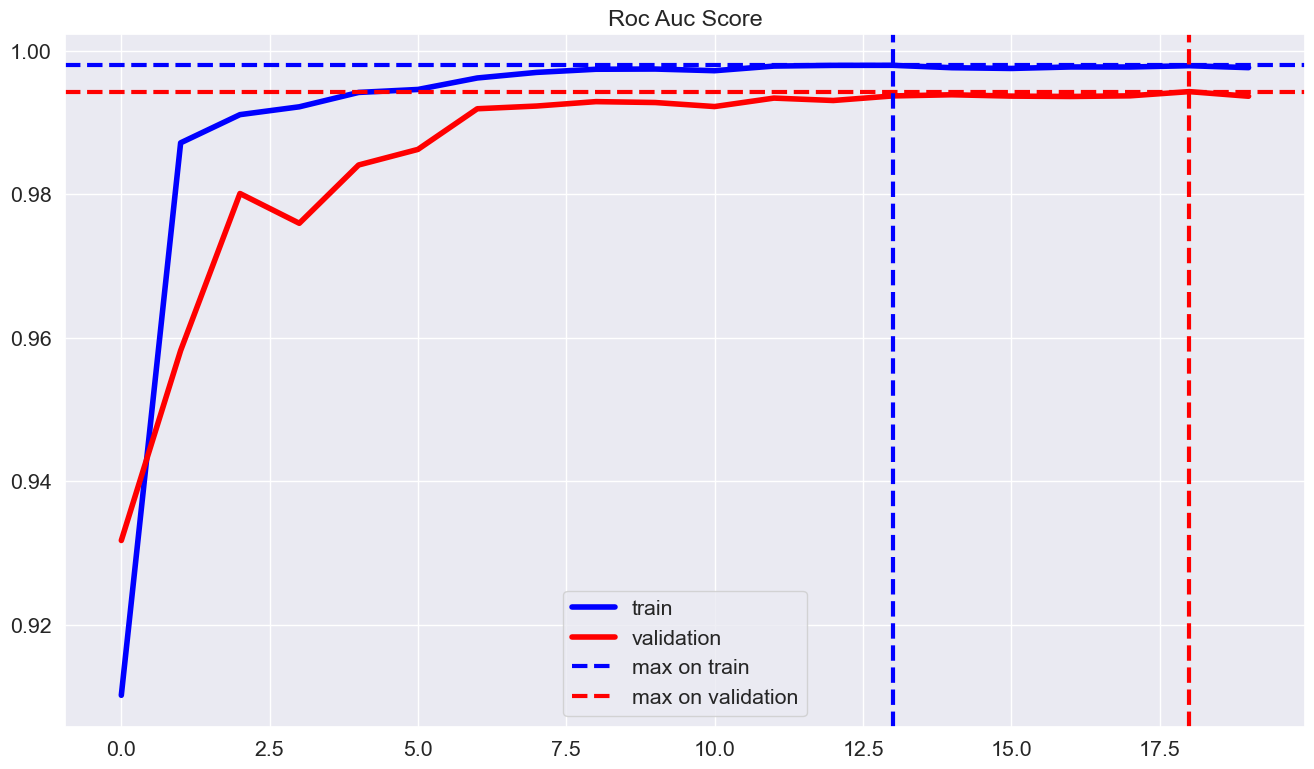

In [13]:
baselines.train_plot(two_fc_losses, two_fc_accuracies, two_fc_roc_aucs)

SUMMARY

change of activation functions miserably affects performance

two weighted layers: best stats shows the model with batchnorm, however it still overfits starting from epoch 15.

three weighted layers: stats are permanently worse, overfitting is faster => final model's classifier should be three-layered (one input, one hidden, one output)

best params are: lr = 1e-3, gamma = 0.2, step_size = 6.

#### MAKING FINAL MODELS FOR RUSSIAN AND ENGLISH

In [ ]:
from torch.optim import lr_scheduler

eng_md_final = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V2')
eng_md_final = freeze_layers(eng_md_final, 4)

eng_md_final.classifier = nn.Sequential(
    nn.Linear(960, 158),
    nn.BatchNorm1d(num_features=158),
    nn.ReLU(158),
    nn.Linear(158, 26), 
    nn.Softmax(dim=-1)
)
eng_md_final = eng_md_final.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(eng_md_final.parameters(), lr=1e-3)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.2)

eng_md_final_trained, eng_md_final_losses, eng_md_final_accuracies, eng_md_final_aucs = baselines.train(eng_md_final, loss_fn, optimizer, lr_scheduler, dataloaders, dataset_sizes, num_epochs=15, verbose=1, savename='eng_md_prod')
torch.cuda.empty_cache()

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training complete in 8.0m 15.7659s
Best val Acc: 0.9252
Best val Roc-Auc: 0.9984


In [5]:
from torch.optim import lr_scheduler

rus_md_final = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V2')
rus_md_final = freeze_layers(rus_md_final, 4)

rus_md_final.classifier = nn.Sequential(
    nn.Linear(960, 175),
    nn.BatchNorm1d(num_features=175),
    nn.ReLU(175),
    nn.Linear(175, 32), 
    nn.Softmax(dim=-1)
)
rus_md_final = rus_md_final.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rus_md_final.parameters(), lr=1e-3)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.2)

rus_labels = [i for i in range(32)]
rus_md_final_trained, rus_md_final_losses, rus_md_final_accuracies, rus_md_final_aucs = baselines.train(rus_md_final, loss_fn, optimizer, lr_scheduler, dataloaders_rus, dataset_sizes_rus,\
                                                                                                        num_epochs=15, verbose=2, savename='rus_new_dataset', class_labels=rus_labels)
torch.cuda.empty_cache()

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

train iter:   0%|          | 0/166 [00:00<?, ?it/s]

val iter:   0%|          | 0/69 [00:00<?, ?it/s]

Training complete in 9.0m 51.6970s
Best val Acc: 0.9461
Best val Roc-Auc: 0.9983


In [7]:
eng_md_final.load_state_dict(torch.load('models/eng_md_prod'))
eng_md_final.eval()
torch.save(eng_md_final, 'models/ENG_PROD.pth')

rus_md_final.load_state_dict(torch.load('models/rus_new_dataset'))
rus_md_final.eval()
torch.save(rus_md_final, 'models/RUS_PROD.pth')